# Поиск каверов композиций
<br>Разработка ML-модели для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам

<br>**Описание проекта**
<br>Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей.
<br>Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков.
<br>Например:
- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

<br>**Цель проекта**
<br>Необходимо разработать ML-продукт, который:
- классифицирует треки по признаку кавер-некавер;
- связывает (группирует) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

<br>**Описание данных**
- Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:
    - track_id - уникальный идентификатор трека;
    - track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
    - original_track_id - уникальный идентификатор исходного трека.
- Метаинформация:
    - track_id - уникальный идентификатор трека;
    - dttm - первая дата появления информации о треке;
    - title - название трека;
    - language - язык исполнения;
    - isrc - международный уникальный идентификатор трека;
    - genres - жанры;
    - duration - длительность трека.
- Текст песен:
    - track_id - уникальный идентификатор трека;
    - lyricId - уникальный идентификатор текста;
    - text - текст трека.

<br>**Целевые метрики**

1. ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) является метрикой, которая оценивает качество бинарной классификации, учитывая полноту (True Positive Rate) и специфичность (True Negative Rate) модели. ROC-AUC измеряет способность модели различать между классами и представляет площадь под кривой ROC. ROC-AUC особенно полезна, когда важно контролировать баланс между ложно-положительными и ложно-отрицательными предсказаниями. Она также устойчива к несбалансированным классам.
2. F1-мера является метрикой, которая оценивает точность и полноту модели для бинарной классификации. F1-мера является гармоническим средним между точностью (precision) и полнотой (recall). Она особенно полезна, когда важно достичь баланса между точностью и полнотой. F1-мера хорошо работает, когда классы сбалансированы или когда важно минимизировать как ложно-положительные, так и ложно-отрицательные предсказания.

## Импорт библиотек

In [5]:
# !pip install sentence-transformers #-U
# !pip install lyricsgenius
# !pip install gensim
# !pip install catboost

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import torch
import warnings
import transformers
from sentence_transformers import SentenceTransformer
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Установка констант

In [7]:
RS = 42 # random state
MAX_TOKEN_LEN = 512 # ограничение на максимальную длину токена

## EDA

### Загрузка данных

In [8]:
try:
    drive.mount('/content/drive')
    covers = pd.read_json('./drive/MyDrive/Colab Notebooks/music_covers/covers.json', orient='records', lines=True)
    lyrics = pd.read_json('./drive/MyDrive/Colab Notebooks/music_covers/lyrics.json', orient='records', lines=True)
    meta = pd.read_json('./drive/MyDrive/Colab Notebooks/music_covers/meta.json', orient='records', lines=True)
    print('загружено из каталога "Colab Notebooks"')
except:
    covers = pd.read_json('data/covers.json', orient='records', lines=True)
    lyrics = pd.read_json('data/lyrics.json', orient='records', lines=True)
    meta = pd.read_json('data/meta.json', orient='records', lines=True)
    print('загружено из каталога "data"')

np.array(covers).shape, np.array(lyrics).shape, np.array(meta).shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
загружено из каталога "Colab Notebooks"


((71597, 3), (11414, 3), (71769, 7))

### Датафрейм `lyrics`

In [9]:
lyrics.info()
display(lyrics.sample(3))
print('явные повторы строк:', lyrics.duplicated().sum())
display('количество уникальных записей:', lyrics.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


,lyricId,text,track_id
4494,4494eb2387accad8eadcc820b1e0808f,When i'm with you\nI'm feeling like the sky's ...,5178dac1aa69d6ab29975a02f73ec870
4381,0845faeeb976ab61c9776002db8c8255,"Как будто все что было, я все выдумал\nТы гово...",a16ace9fa160c23df1f9de2ebd7fd2fc
7659,d4f48d16618c0051424d62ea9ea785de,Now I see there's things in my way\nPush it 't...,abf0759fe2124386f25fd96e93be2cad


явные повторы строк: 0


'количество уникальных записей:'

lyricId     10915
text        10644
track_id    10277
dtype: int64

Выводы:
- тексты представлены на различных языках (английский, русский, испанский)
- явных повторов строк не обнаружено, при этом количество уникальных ID текстов и треков меньше,
  <br>чем всего строк, что означает использование текстов в других треках

### Датафрейм `meta`

In [10]:
meta.info()
display(meta.sample()) #genres - list
print('явные повторы строк:', meta[['track_id', 'dttm', 'title', 'language', 'isrc', 'duration']].duplicated().sum())
display('количество уникальных записей:', meta[['track_id', 'dttm', 'title', 'language', 'isrc', 'duration']].nunique())
display('список представленных стран:', meta['language'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


,track_id,dttm,title,language,isrc,genres,duration
54881,f88c2349e9370beb73526f32720c30cc,1.597762e+12,Soy Feliz,None,QZHZ62090125,[SKA],194820.0


явные повторы строк: 0


'количество уникальных записей:'

track_id    71768
dttm        27726
title       45462
language       85
isrc        71283
duration    23597
dtype: int64

'список представленных стран:'

array(['EN', None, 'ES', 'HI', 'DE', 'RU', 'TR', 'HU', 'TH', 'PL', 'FR',
       'NY', 'AF', 'AS', 'UZ', 'HT', 'EL', 'AZ', 'IT', 'PA', 'PT', 'TA',
       'JA', 'ML', 'VI', 'ID', 'LA', 'CS', 'SI', 'UK', 'OR', 'HR', 'AR',
       'KK', 'FI', 'IE', 'ZH', 'AB', 'KN', 'FA', 'BN', 'TL', 'SK', 'KS',
       'SV', 'RO', 'TN', 'KO', 'MS', 'BM', 'HY', 'TW', 'MY', 'CA', 'NL',
       'ET', 'TE', 'MN', 'HE', 'SQ', 'IG', 'MR', 'BE', 'LT', 'UR', 'IA',
       'GN', 'SW', 'NO', 'GU', 'KY', 'KU', 'IS', 'TG', 'SR', 'DA', 'LO',
       'LV', 'SE', 'WO', 'SA', 'YO', 'ST', 'HA', 'AV', 'IU'], dtype=object)

In [ ]:
# from datetime import datetime

# unix_timestamp1 = 1.555760e+12
# unix_timestamp2 = 1.626110e+12

# # Преобразование временной метки в объект datetime
# dt1 = datetime.fromtimestamp(unix_timestamp1 / 1000) #2019-04-20 14:33:20
# dt2 = datetime.fromtimestamp(unix_timestamp2 / 1000) #2021-07-12 20:13:20

# print(dt1 < dt2) #True
# unix_timestamp1 < unix_timestamp2 #True

Выводы:
- явных повторов строк не обнаружено
- количество стран в колонке `language` - 85
- информация о странах внесена менее, чем в 30% записей
- все `track_id` уникальны
- даты представлены в unix формате
- можно удалить признаки:
  - `duration` - не несёт важной информации, т.к. продолжительность кавера может отличаться от исходника
  - `genres` - не несёт важной информации, т.к. жанр кавера может отличаться от исходника
  - `isrc` - не несёт важной информации, т.к. имеется признак `track_id`, а ещё в нём есть пропуски

### Датафрейм `covers`

In [11]:
covers.info()
display(covers.sample())
print('явные повторы строк:', covers.duplicated().sum())
display('количество уникальных записей:', covers.nunique())
print('оригинальных треков указано:', round(covers['original_track_id'].count() / covers['track_id'].count() * 100, 2), '% записей')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


,original_track_id,track_id,track_remake_type
21461,None,624e2bad60290fd7b82696f5edd758c0,COVER


явные повторы строк: 0


'количество уникальных записей:'

original_track_id     4468
track_id             71597
track_remake_type        2
dtype: int64

оригинальных треков указано: 6.73 % записей


Выводы:
- явных повторов строк не обнаружено
- количество указанных оригинальных треков - 6.73 % от общего числа треков

In [12]:
filled_data = covers.dropna(subset=['track_remake_type'])
filled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


### Объединение датафреймов

In [13]:
cover_lyric = (filled_data
               .merge(lyrics, on='track_id', how='left')
               .merge(meta[['track_id', 'dttm']], on='track_id', how='left')
              ) # объединение по левой таблице
cover_lyric_wona = cover_lyric.dropna(subset=['text', 'original_track_id']).reset_index(drop=True) # удаление пропусков
cover_lyric_wona = cover_lyric_wona.drop(['lyricId'], axis=1) # удаление колонки lyricId

cover_lyric_wona.shape

(3599, 5)

Вывод:
- данные объединены с сохранением признака кавера
- из данных удалены пропущенные значения
- удалены ненужные признаки

### Кодирование текстов

#### SentenceTransformer

In [14]:
sentences = np.array(cover_lyric_wona['text'])

# model = SentenceTransformer('all-MiniLM-L6-v2')  # архитектура MiniLM (время выполнения ~ 5 мин)
model = SentenceTransformer('sentence-transformers/LaBSE')  # архитектура LaBSE (Language-agnostic BERT Sentence Embedding) (~ 70 мин)

sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

(3599, 768)

Вывод:
- получены эмбеддинги текстов при помощи библиотеки `sentence_transformer` на архитектуре LaBSE
- выбор данной архитектуры обусловлен её способностью распознавать и сравнивать тексты на более, чем 100 языках
- затраченное на обучение время: 70 минут

Соединение закодированных текстов с исходными данными

In [15]:
df_work = cover_lyric_wona.copy()
df_work = df_work.join(pd.DataFrame(sentence_embeddings), how='left')
df_work.head()

,original_track_id,track_id,track_remake_type,text,dttm,0,1,2,3,4,...,758,759,760,761,762,763,764,765,766,767
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,Left a good job in the city\nWorkin' for the m...,1.257973e+12,-0.071151,-0.000550,-0.015525,-0.068183,-0.017857,...,0.037262,-0.010959,0.025177,0.026895,0.004867,-0.043662,-0.015377,-0.008442,-0.041558,-0.055484
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,Left a good job in the city\nWorkin' for the m...,1.257973e+12,-0.072601,-0.008105,-0.007002,-0.066120,-0.022410,...,0.040421,-0.008107,0.017281,0.025594,0.005750,-0.043891,-0.017041,-0.004621,-0.034674,-0.053124
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,Some folks are born made to wave the flag\nOoh...,1.257973e+12,-0.053419,-0.000123,-0.033951,-0.025266,-0.025993,...,-0.007231,0.005841,-0.020928,0.031590,0.011153,-0.046689,0.015612,0.051465,-0.066878,-0.074791
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",1.253563e+12,-0.056900,-0.049212,-0.031589,-0.068017,-0.026555,...,0.043457,-0.031792,-0.022746,-0.008788,-0.046626,-0.038060,-0.037003,-0.044537,-0.064605,-0.051017
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,"Yeah!... yeah!... remember the time, baby... y...",1.258405e+12,-0.037682,-0.028061,-0.063845,-0.062088,-0.006575,...,-0.020223,-0.016452,-0.013310,0.005944,-0.021391,-0.046816,-0.019437,-0.019671,-0.063563,-0.059268


Вывод:
- закодированные тексты присоединены к основному датафрейму

#### Bert transformer

In [47]:
cover_lyric_wona_r = cover_lyric_wona.loc[:3499]
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tokenized = cover_lyric_wona_r['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors


Применение паддинга к векторам

In [48]:
padded = np.array([i[:MAX_TOKEN_LEN] + [0]*(MAX_TOKEN_LEN - len(i[:MAX_TOKEN_LEN]))\
                   if len(i) > MAX_TOKEN_LEN else i + [0]*(MAX_TOKEN_LEN - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
attention_mask = torch.tensor(attention_mask, dtype=torch.long).to(device)

Инициализируем модель класса BertModel. Передадим ей файл с предобученной моделью

In [49]:
model_bert = transformers.BertModel.from_pretrained('bert-base-multilingual-cased').to(device)

Преобразование текстов в эмбеддинги

In [50]:
batch_size = 100
bert_embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
  batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
  attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)]
  with torch.no_grad():
    batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
    bert_embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/35 [00:00<?, ?it/s]

Функция для разделения списков

In [44]:
def f(gen):
    return pd.Series(gen, dtype='float64')

Добавление эмбеддингов к датафрейму

In [51]:
bert_embedding = np.concatenate(bert_embeddings) # сбор в матрицу
df_e = cover_lyric_wona_r[['text', 'track_remake_type']] # эмбендинги общим списком в данные df_e
df_e['embedding'] = bert_embedding.tolist() # преобразование в список
ren = df_e['embedding'].apply(f) # применение функции разделения к данным

df_o = cover_lyric_wona_r.copy() # создание нового датафрейма
df_o = df_o.drop('text', axis=1)

df_o = pd.concat([df_o, ren], axis=1) # Добавление новых столбцов к датафрейму

display('количество пропущенных значений:', df_o.isna().sum().sum())
df_o.shape

'количество пропущенных значений:'

0

(3500, 772)

Вывод:
- получены эмбеддинги текстов при помощи мультиязычного трансформера на базе Bert
- эмбеддинги добавлены к основным данным
- затраченное на обучение время: 2 минуты

### Подготовка к обучению

In [52]:
'соотношение классов:', round(df_work['track_remake_type'].value_counts()[1] / df_work['track_remake_type'].value_counts()[0], 2)

('соотношение классов:', 0.12)

Вывод:
- в данных наблюдается сильный дисбаланс классов
- при разделении на выборки необходимо учесть этот момент

## Machine learning

### XGBoost на эмбеддингах SentenceTransformer

In [53]:
df_tr = df_work.copy()
X = df_tr.drop(['original_track_id', 'track_id', 'track_remake_type', 'text'], axis=1)
y = df_tr['track_remake_type']
y = (y != 'ORIGINAL').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RS,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2879, 769), (720, 769), (2879,), (720,))

Вывод:
- данные поделены на обучающую и тестовую выборки с учётом дисбаланса классов

In [56]:
# Преобразование данных в формат DMatrix
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

# Определение параметров модели
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 3
}

# Обучение модели
model = xgboost.train(params, dtrain, evals=[(dtest, 'Test')], num_boost_round=1000, verbose_eval=100)

# Получение предсказаний на тестовом наборе данных
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Вычисление ROC-AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', round(auc, 2))

# Вычисление F1-меры
f1 = f1_score(y_test, y_pred_binary)
print("F1-мера:", round(f1, 2))

[0]	Test-auc:0.83211
[100]	Test-auc:0.92788
[200]	Test-auc:0.92418
[300]	Test-auc:0.92186
[400]	Test-auc:0.91983
[500]	Test-auc:0.92048
[600]	Test-auc:0.91886
[700]	Test-auc:0.91783
[800]	Test-auc:0.91647
[900]	Test-auc:0.91752
[999]	Test-auc:0.91709
ROC-AUC: 0.92
F1-мера: 0.68


Вывод:
- при обучении `XGBoost` получены метрики `ROC-AUC: 0.92`, `F1-мера: 0.68` на тестовых данных

### CatBoost на эмбеддингах Bert

In [70]:
df_tr_b = df_o.copy()
X_bert_em = df_tr_b.drop(['original_track_id', 'track_id', 'track_remake_type'], axis=1)
y_bert_m = df_tr_b['track_remake_type']
y_bert_m = (y_bert_m != 'ORIGINAL').astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bert_em,
                                                            y_bert_m,
                                                            test_size=0.2,
                                                            random_state=RS,
                                                            stratify=y_bert_m)
X_train_b.shape, X_test_b.shape, y_train_b.shape, y_test_b.shape

((2800, 769), (700, 769), (2800,), (700,))

Вывод:
- данные разделены на выборки с учётом дисбаланса классов

In [79]:
model_cat = CatBoostClassifier(random_state=RS, eval_metric='AUC') # инициализация модели
model_cat.fit(X_train_b, y_train_b, eval_set=(X_test_b, y_test_b), verbose=100, plot=True) # обучение модели

# Вычисление и вывод ROC-AUC
y_pred_proba_cat = model_cat.predict_proba(X_test_b)[:, 1]
roc_auc_cat = roc_auc_score(y_test_b, y_pred_proba_cat)
print("ROC-AUC на тестовой выборке:", roc_auc_cat)

# Вычисление F1-меры
y_pred_b = model_cat.predict(X_test_b) # получение предсказаний на тестовой выборке
y_pred_binary_c = [1 if p >= 0.5 else 0 for p in y_pred_b]
f1 = f1_score(y_test_b, y_pred_binary_c)
print("F1-мера на тестовой выборке:", f1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.040866
0:	test: 0.6451307	best: 0.6451307 (0)	total: 393ms	remaining: 6m 32s
100:	test: 0.8317227	best: 0.8317227 (100)	total: 23.9s	remaining: 3m 33s
200:	test: 0.8409173	best: 0.8409173 (200)	total: 43s	remaining: 2m 51s
300:	test: 0.8511360	best: 0.8516693 (296)	total: 1m 2s	remaining: 2m 25s
400:	test: 0.8537173	best: 0.8540160 (395)	total: 1m 23s	remaining: 2m 4s
500:	test: 0.8577280	best: 0.8577280 (500)	total: 1m 42s	remaining: 1m 42s
600:	test: 0.8580267	best: 0.8585173 (552)	total: 2m 2s	remaining: 1m 21s
700:	test: 0.8598187	best: 0.8609493 (659)	total: 2m 22s	remaining: 1m
800:	test: 0.8592000	best: 0.8609493 (659)	total: 2m 43s	remaining: 40.6s
900:	test: 0.8585173	best: 0.8609493 (659)	total: 3m 3s	remaining: 20.2s
999:	test: 0.8598187	best: 0.8609493 (659)	total: 3m 24s	remaining: 0us

bestTest = 0.8609493333
bestIteration = 659

Shrink model to first 660 iterations.
ROC-AUC на тестовой выборке: 0.8609493333333333
F1-мера на тестовой выборке: 0.4380

Вывод:
- при обучении `CatBoost` получены метрики `ROC-AUC: 0.86`, `F1-мера: 0.43` на тестовых данных

### LogisticRegression на эбеддингах Bert

F1-мера на обучающей выборке: 0.0
F1-мера на тестовой выборке: 0.0
ROC-AUC на тестовой выборке: 0.57


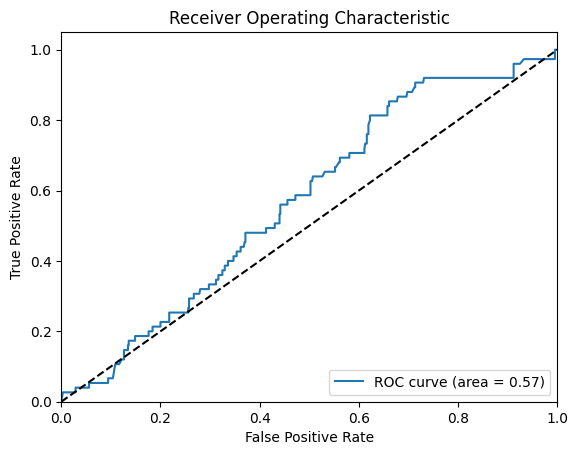

In [90]:
model_lg = LogisticRegression(random_state=RS, max_iter=1000)
model_lg.fit(X_train_b.values, y_train_b)

y_pred_tr_lg = model_lg.predict(X_train_b.values) # предсказания на обучающей выборке

# Вычисление F1-меры для обучабщей выыборки
y_pred_binary_lg = [1 if p >= 0.5 else 0 for p in y_pred_tr_lg]
f1 = f1_score(y_train_b, y_pred_binary_lg)
print("F1-мера на обучающей выборке:", f1)

# Вычисление F1-меры для тестовой выборки
y_pred_t = model_lg.predict(X_test_b.values)
y_pred_binary_tlg = [1 if p >= 0.5 else 0 for p in y_pred_t]
f1 = f1_score(y_test_b, y_pred_binary_tlg)
print("F1-мера на тестовой выборке:", f1)

# Вычисление ROC-AUC
y_pred_proba_lg = model_lg.predict_proba(X_test_b.values)[:, 1]
roc_auc_lg = roc_auc_score(y_test_b, y_pred_proba_lg)
print("ROC-AUC на тестовой выборке:", round(roc_auc_lg, 2))

# Визуализация кривой ROC
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test_b, y_pred_proba_lg)
plt.plot(fpr_lg, tpr_lg, label='ROC curve (area = %0.2f)' % roc_auc_lg)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Вывод:

- при обучении `LogisticRegression` получены метрики `ROC-AUC: 0.57`, `F1-мера: 0.0` на тестовых данных

## Заключение:
- в решении поставленной задачи основными признаками приняты текст и дата появления трека
- целевой метрикой выбрана roc-auc, т.к. она устойчива к дисбалансу классов, который присущ предоставленным данным
- при кодировании текстов использованы два трансформера: SentenceTransformer, Bert transformer
- для обучения использовались признаки: дата выхода трека, эмбеддинги
- целевой признак - метка оригинал/кавер
- удалённые признаки:
  - ID треков и текстов (чтобы модель была более универсальной)
  - текст - удалён, т.к. есть его эмбеддинги
  - язык, продолжительность, жанр - удалены, т.к. сами по себе данные признаки не информативны для решения поставленной задачи
- при обучении выбирали лучшую из моделей: XGBoost, CatBoost, LogisticRegression
- наилучший результат по выбранной метрике показала модель: XGBoost
- не реализованные идеи:
  - пробовали использовать библиотеку MusicMetaLinker для обогащения предоставленных данных, но для полноценного использования не хватило отведённого времени
  - рассматривали алгоритм Doc2Vec, для полноценного изучения не хватило времени